# Inspect the model performance for log return as targets

## Model(s)

For each target with different forward time window, e.g., 24h, 48, 120h, we trained 9 lgbm models to predict the quantile values.

Dataset is splitted into train/val/test, train is used for hyperparameter tuning and actual training, while val is only for early stopping, and test is for out of sample test.

## Test strategy

1. We combined the quantile predictions into expected log return (check docs/calculate_signals_from_logreturn.md), and also use piecewise-linear interpolation to estimate of probability of positive return.
2. The strategy only assumes we always open a position at open_t+1, and close it at close_t+N, N depends on which forward time window is. For simplicity, there is no other condition used (like stop loss, take profit, fees or compounding of size)
3. The entry signal for long or short is decided by three numbers from model predictions: expected log return `exp_ret_avg`, median quantile log return prediction `pred_q50` and probability of positive return `prob_up`. Long when `exp_ret_avg` > `pred_q50` > 0 AND `prob_up` >= long_threshold, short when `exp_ret_avg` < `pred_q50` < 0 AND `prob_up` <= short_threshold

In [60]:
# Ensure project root is on sys.path for 'strategies' imports
import sys
from pathlib import Path

ROOT = Path.cwd().parents[0]
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Quick import check (optional)
try:
    from strategies.quantile_signals import estimate_prob_up
except Exception as e:
    print("Import warning:", e)
    # Fallback if needed: from quantile_signals import estimate_prob_up


In [61]:
# plot function
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Tuple


def plot_y_true_with_signal_colors(
    df: pd.DataFrame,
    ts_col: str = "timestamp",
    y_col: str = "y_true",
    signal_col: str = "signal_prob_exp_q50",
    figsize: Tuple[float, float] = (12, 4),
    title: Optional[str] = None,
    long_color: str = "#2ca02c",
    short_color: str = "#d62728",
    flat_color: str = "#b0b0b0",
    line_alpha: float = 0.6,
    marker_size: float = 8.0,
):
    """Plot y_true vs timestamp and color-mark long/short trades on the line.

    - Plots a light grey line for the full y_true series
    - Overlays scatter points where signal>0 (long) and signal<0 (short)

    Args:
        df: DataFrame containing timestamp, y_true, and signal columns
        ts_col: name of timestamp column
        y_col: name of y_true column (log returns)
        signal_col: name of signal column (-1/0/1)
        figsize: figure size
        title: optional title; defaults to f"{y_col} with {signal_col}"
        long_color: color for long markers
        short_color: color for short markers
        flat_color: unused (reserved if flat markers needed)
        line_alpha: alpha for base line
        marker_size: marker size for scatter points

    Returns:
        matplotlib Axes
    """
    if ts_col not in df.columns:
        raise KeyError(f"Column '{ts_col}' not found in DataFrame")
    if y_col not in df.columns:
        raise KeyError(f"Column '{y_col}' not found in DataFrame")
    if signal_col not in df.columns:
        raise KeyError(f"Column '{signal_col}' not found in DataFrame")

    ts = pd.to_datetime(df[ts_col], errors="coerce")
    y = pd.to_numeric(df[y_col], errors="coerce")
    s = pd.to_numeric(df[signal_col], errors="coerce").fillna(0).astype(int)

    fig, ax = plt.subplots(figsize=figsize)

    # Base line for y_true
    ax.plot(ts, y, color="#cccccc", linewidth=1.2, alpha=line_alpha, label=y_col)

    # Overlay long/short markers
    longs = s > 0
    shorts = s < 0

    if longs.any():
        ax.scatter(ts[longs], y[longs], c=long_color, s=marker_size, label="Long", zorder=3)
    if shorts.any():
        ax.scatter(ts[shorts], y[shorts], c=short_color, s=marker_size, label="Short", zorder=3)

    ax.set_xlabel("timestamp")
    ax.set_ylabel(y_col)
    if title is None:
        title = f"{y_col} with {signal_col}"
    ax.set_title(title)
    ax.legend(loc="best")
    ax.grid(True, alpha=0.2)
    fig.autofmt_xdate()
    plt.tight_layout()
    return ax


# Result for 24h log return

In [62]:
from pathlib import Path
import pandas as pd

# Paths
root = Path("/Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_24h_new")
train_csv = root / "pred_train_signals.csv"
val_csv = root / "pred_val_signals.csv"
test_csv = root / "pred_test_signals.csv"

# Load
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

for df in (train_df, val_df, test_df):
    if 'timestamp' in df.columns:
        ts = pd.to_datetime(df['timestamp'], errors='coerce', utc=True)
        df['timestamp'] = ts.dt.tz_convert('UTC').dt.tz_localize(None)

print("Loaded:")
print("train:", train_df.shape, train_csv)
print("val:", val_df.shape, val_csv)
print("test:", test_df.shape, test_csv)

train_df.head(), val_df.head(), test_df.head()


Loaded:
train: (15521, 20) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_24h_new/pred_train_signals.csv
val: (3325, 20) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_24h_new/pred_val_signals.csv
test: (3327, 20) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_24h_new/pred_test_signals.csv


(            timestamp    y_true  pred_q05  pred_q10  pred_q15  pred_q25  \
 0 2023-01-31 00:00:00  0.010941 -0.019151 -0.019151  -0.01823 -0.011601   
 1 2023-01-31 01:00:00  0.012641 -0.020602 -0.020602  -0.01823 -0.011601   
 2 2023-01-31 02:00:00  0.010933 -0.020865 -0.020865  -0.01823 -0.011601   
 3 2023-01-31 03:00:00  0.013083 -0.021053 -0.021053  -0.01823 -0.011601   
 4 2023-01-31 04:00:00  0.011877 -0.019780 -0.019780  -0.01823 -0.011601   
 
    pred_q50  pred_q75  pred_q85  pred_q90  pred_q95  cross_violations  \
 0  0.001071  0.011569  0.030306  0.030306  0.040792                 2   
 1  0.001071  0.014240  0.029683  0.029683  0.040402                 2   
 2  0.001071  0.013141  0.029496  0.029496  0.039768                 2   
 3  0.001071  0.014836  0.029496  0.029496  0.041326                 2   
 4  0.001071  0.013855  0.029496  0.029496  0.038519                 2   
 
    max_cross_gap  exp_ret_avg  exp_ret_conservative   prob_up  tail_spread  \
 0       0.006562

In [63]:
# Load original merged predictions (no signals)
orig_train_csv = root / "pred_train.csv"
orig_val_csv = root / "pred_val.csv"
orig_test_csv = root / "pred_test.csv"

orig_train_df = pd.read_csv(orig_train_csv)
orig_val_df = pd.read_csv(orig_val_csv)
orig_test_df = pd.read_csv(orig_test_csv)

for df in (orig_train_df, orig_val_df, orig_test_df):
    if 'timestamp' in df.columns:
        ts = pd.to_datetime(df['timestamp'], errors='coerce', utc=True)
        df['timestamp'] = ts.dt.tz_convert('UTC').dt.tz_localize(None)

print("Loaded originals:")
print("train:", orig_train_df.shape, orig_train_csv)
print("val:", orig_val_df.shape, orig_val_csv)
print("test:", orig_test_df.shape, orig_test_csv)

orig_train_df.head(), orig_val_df.head(), orig_test_df.head()


Loaded originals:
train: (15521, 11) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_24h_new/pred_train.csv
val: (3325, 11) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_24h_new/pred_val.csv
test: (3327, 11) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_24h_new/pred_test.csv


(            timestamp    y_true  pred_q05  pred_q10  pred_q15  pred_q25  \
 0 2023-01-31 00:00:00  0.010941 -0.019151 -0.025713  -0.01823 -0.011601   
 1 2023-01-31 01:00:00  0.012641 -0.020602 -0.025713  -0.01823 -0.011601   
 2 2023-01-31 02:00:00  0.010933 -0.020865 -0.025713  -0.01823 -0.011601   
 3 2023-01-31 03:00:00  0.013083 -0.021053 -0.025713  -0.01823 -0.011601   
 4 2023-01-31 04:00:00  0.011877 -0.019780 -0.025713  -0.01823 -0.011601   
 
    pred_q50  pred_q75  pred_q85  pred_q90  pred_q95  
 0  0.001071  0.011569  0.030306  0.026019  0.040792  
 1  0.001071  0.014240  0.029683  0.024995  0.040402  
 2  0.001071  0.013141  0.029496  0.024995  0.039768  
 3  0.001071  0.014836  0.029496  0.025010  0.041326  
 4  0.001071  0.013855  0.029496  0.026596  0.038519  ,
             timestamp    y_true  pred_q05  pred_q10  pred_q15  pred_q25  \
 0 2024-11-07 17:00:00  0.001505 -0.046409 -0.025931 -0.018104 -0.009319   
 1 2024-11-07 18:00:00  0.002558 -0.047622 -0.025931 -0.018

In [64]:
import numpy as np

def add_prob_exp_q50_indicator(
    signals_df: pd.DataFrame,
    original_df: pd.DataFrame,
    tau_long: float = 0.55,
    tau_short: float = 0.45,
    exp_col: str = "exp_ret_avg",
    out_col: str = "signal_prob_exp_q50",
) -> pd.DataFrame:
    """Add a -1/0/1 indicator based on prob_up, expected return, and original pred_q50.

    Long rule:  prob_up >= tau_long and exp_col > pred_q50_orig > 0  →  +1
    Short rule: prob_up <  tau_short and exp_col < pred_q50_orig < 0  →  -1
    Else 0.
    """
    if "prob_up" not in signals_df.columns:
        raise KeyError("signals_df must contain 'prob_up'")
    if exp_col not in signals_df.columns:
        raise KeyError(f"signals_df must contain '{exp_col}'")
    if "pred_q50" not in original_df.columns:
        raise KeyError("original_df must contain 'pred_q50'")

    merged = signals_df.copy()
    if "timestamp" in signals_df.columns and "timestamp" in original_df.columns:
        q50_map = original_df[["timestamp", "pred_q50"]].rename(columns={"pred_q50": "pred_q50_orig"})
        merged = merged.merge(q50_map, on="timestamp", how="left")
    else:
        # Fallback: align by row order
        merged["pred_q50_orig"] = original_df["pred_q50"].values[: len(merged)]

    prob = pd.to_numeric(merged["prob_up"], errors="coerce")
    expv = pd.to_numeric(merged[exp_col], errors="coerce")
    q50o = pd.to_numeric(merged["pred_q50_orig"], errors="coerce")

    cond_long = (prob >= float(tau_long)) & (expv > q50o) & (q50o > 0.0)
    cond_short = (prob < float(tau_short)) & (expv < q50o) & (q50o < 0.0)
    indicator = np.where(cond_long, 1, np.where(cond_short, -1, 0)).astype(int)

    out = merged.copy()
    out[out_col] = indicator
    return out

# Add indicator to each split
train_ind = add_prob_exp_q50_indicator(train_df, orig_train_df, tau_long=0.52, tau_short=0.48, exp_col="exp_ret_avg", out_col="signal_prob_exp_q50")
val_ind = add_prob_exp_q50_indicator(val_df, orig_val_df, tau_long=0.52, tau_short=0.48, exp_col="exp_ret_avg", out_col="signal_prob_exp_q50")
test_ind = add_prob_exp_q50_indicator(test_df, orig_test_df, tau_long=0.52, tau_short=0.48, exp_col="exp_ret_avg", out_col="signal_prob_exp_q50")

print("Indicator value counts (train/val/test):")
print(train_ind["signal_prob_exp_q50"].value_counts().sort_index())
print(val_ind["signal_prob_exp_q50"].value_counts().sort_index())
print(test_ind["signal_prob_exp_q50"].value_counts().sort_index())

train_ind.head(), val_ind.head(), test_ind.head()


Indicator value counts (train/val/test):
signal_prob_exp_q50
-1     989
 0    9721
 1    4811
Name: count, dtype: int64
signal_prob_exp_q50
-1      32
 0    2886
 1     407
Name: count, dtype: int64
signal_prob_exp_q50
0    2902
1     425
Name: count, dtype: int64


(            timestamp    y_true  pred_q05  pred_q10  pred_q15  pred_q25  \
 0 2023-01-31 00:00:00  0.010941 -0.019151 -0.019151  -0.01823 -0.011601   
 1 2023-01-31 01:00:00  0.012641 -0.020602 -0.020602  -0.01823 -0.011601   
 2 2023-01-31 02:00:00  0.010933 -0.020865 -0.020865  -0.01823 -0.011601   
 3 2023-01-31 03:00:00  0.013083 -0.021053 -0.021053  -0.01823 -0.011601   
 4 2023-01-31 04:00:00  0.011877 -0.019780 -0.019780  -0.01823 -0.011601   
 
    pred_q50  pred_q75  pred_q85  pred_q90  ...  max_cross_gap  exp_ret_avg  \
 0  0.001071  0.011569  0.030306  0.030306  ...       0.006562     0.003349   
 1  0.001071  0.014240  0.029683  0.029683  ...       0.005111     0.003528   
 2  0.001071  0.013141  0.029496  0.029496  ...       0.004849     0.003232   
 3  0.001071  0.014836  0.029496  0.029496  ...       0.004660     0.003621   
 4  0.001071  0.013855  0.029496  0.029496  ...       0.005933     0.003398   
 
    exp_ret_conservative   prob_up  tail_spread  signal_exp  signa

In [65]:
import numpy as np

def evaluate_indicator(df: pd.DataFrame, name: str):
    # Signals: -1/0/1
    s = pd.to_numeric(df['signal_prob_exp_q50'], errors='coerce').fillna(0).astype(int)
    # Log returns
    y_log = pd.to_numeric(df['y_true'], errors='coerce')

    trades = (s != 0)
    num_trades = int(trades.sum())
    wins = (np.sign(y_log[trades]) == s[trades]) & (np.sign(y_log[trades]) != 0)
    win_rate = float(wins.mean()) if num_trades > 0 else float('nan')

    # Per-trade simple return (not compounded): long = exp(y)-1, short = -(exp(y)-1)
    simple_ret = np.exp(y_log) - 1.0
    pnl_pct = s * simple_ret*100  # per-row percentage PnL (not log)

    # Cumulative (non-compounded) percentage PnL
    cumulative_pct = float(pnl_pct.sum())

    if 'timestamp' in df.columns:
        ts = pd.to_datetime(df['timestamp'], errors='coerce', utc=True).dt.tz_convert('UTC').dt.tz_localize(None)
        cum_series = pnl_pct.set_axis(ts).cumsum()
    else:
        cum_series = pnl_pct.cumsum()

    print(f"{name}: trades={num_trades}, win_rate={win_rate:.3f}, cumulative_pct={cumulative_pct:.6f}")
    return cum_series

cum_train = evaluate_indicator(train_ind, 'train')
cum_val = evaluate_indicator(val_ind, 'val')
cum_test = evaluate_indicator(test_ind, 'test')

cum_train.tail(), cum_val.tail(), cum_test.tail()



train: trades=5800, win_rate=0.890, cumulative_pct=12970.123803
val: trades=439, win_rate=0.590, cumulative_pct=370.499352
test: trades=425, win_rate=0.574, cumulative_pct=166.890650


(timestamp
 2024-11-07 12:00:00    12970.123803
 2024-11-07 13:00:00    12970.123803
 2024-11-07 14:00:00    12970.123803
 2024-11-07 15:00:00    12970.123803
 2024-11-07 16:00:00    12970.123803
 dtype: float64,
 timestamp
 2025-03-26 01:00:00    370.499352
 2025-03-26 02:00:00    370.499352
 2025-03-26 03:00:00    370.499352
 2025-03-26 04:00:00    370.499352
 2025-03-26 05:00:00    370.499352
 dtype: float64,
 timestamp
 2025-08-11 16:00:00    166.89065
 2025-08-11 17:00:00    166.89065
 2025-08-11 18:00:00    166.89065
 2025-08-11 19:00:00    166.89065
 2025-08-11 20:00:00    166.89065
 dtype: float64)

<Axes: title={'center': '24h - Test'}, xlabel='timestamp', ylabel='y_true'>

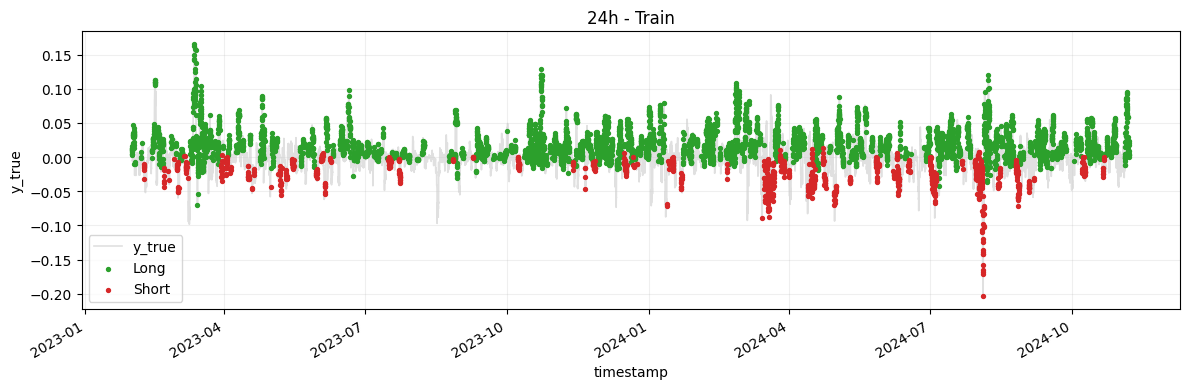

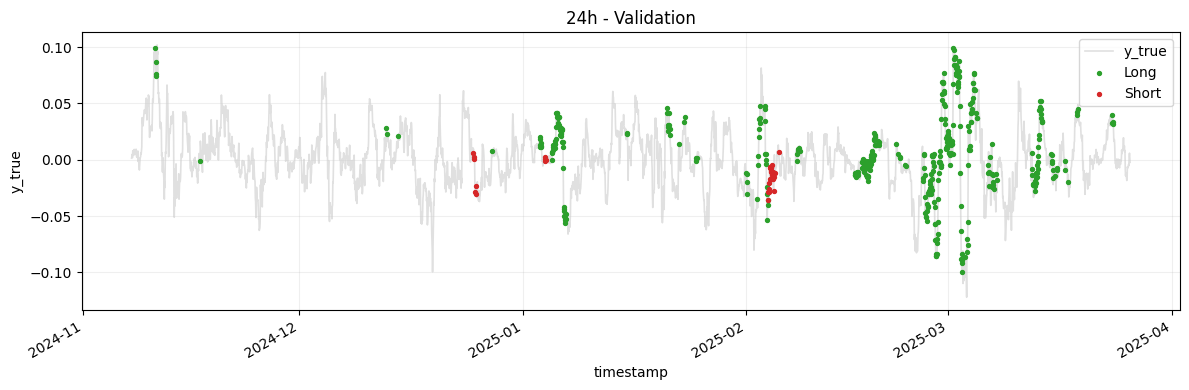

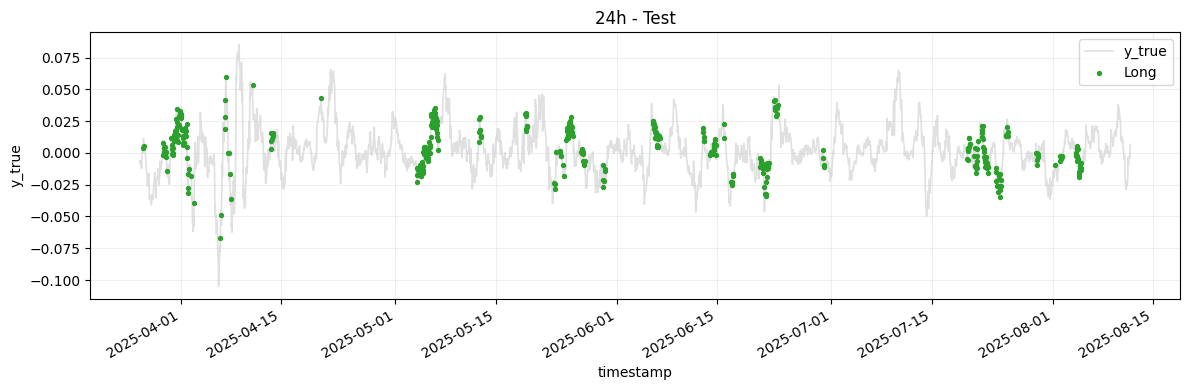

In [66]:
plot_y_true_with_signal_colors(train_ind, title="24h - Train")

plot_y_true_with_signal_colors(val_ind, title="24h - Validation")

plot_y_true_with_signal_colors(test_ind, title="24h - Test")


# Results for 48h log return

## The models' q5 and q10 predictions are straight lines, so I disabled short strategy for it

In [67]:
from pathlib import Path
import pandas as pd

# Paths
root = Path("/Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_48h")
train_csv = root / "pred_train_signals.csv"
val_csv = root / "pred_val_signals.csv"
test_csv = root / "pred_test_signals.csv"

# Load
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

for df in (train_df, val_df, test_df):
    if 'timestamp' in df.columns:
        ts = pd.to_datetime(df['timestamp'], errors='coerce', utc=True)
        df['timestamp'] = ts.dt.tz_convert('UTC').dt.tz_localize(None)

print("Loaded:")
print("train:", train_df.shape, train_csv)
print("val:", val_df.shape, val_csv)
print("test:", test_df.shape, test_csv)

train_df.head(), val_df.head(), test_df.head()


Loaded:
train: (15504, 20) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_48h/pred_train_signals.csv
val: (3322, 20) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_48h/pred_val_signals.csv
test: (3323, 20) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_48h/pred_test_signals.csv


(            timestamp    y_true  pred_q05  pred_q10  pred_q15  pred_q25  \
 0 2023-01-31 00:00:00  0.058260  -0.04241 -0.032459 -0.026026 -0.013325   
 1 2023-01-31 01:00:00  0.048326  -0.04241 -0.032459 -0.026026 -0.013325   
 2 2023-01-31 02:00:00  0.044586  -0.04241 -0.032459 -0.026026 -0.013325   
 3 2023-01-31 03:00:00  0.043946  -0.04241 -0.032459 -0.026026 -0.013325   
 4 2023-01-31 04:00:00  0.044035  -0.04241 -0.032459 -0.026026 -0.013325   
 
    pred_q50  pred_q75  pred_q85  pred_q90  pred_q95  cross_violations  \
 0  0.001399  0.035890  0.051241  0.051241   0.05504                 1   
 1  0.001399  0.035890  0.051241  0.051241   0.05504                 1   
 2  0.001399  0.035890  0.050781  0.050781   0.05504                 1   
 3  0.001399  0.035890  0.050484  0.050484   0.05504                 1   
 4  0.001399  0.037067  0.049506  0.049506   0.05504                 1   
 
    max_cross_gap  exp_ret_avg  exp_ret_conservative   prob_up  tail_spread  \
 0       0.006238

In [68]:
# Load original merged predictions (no signals)
orig_train_csv = root / "pred_train.csv"
orig_val_csv = root / "pred_val.csv"
orig_test_csv = root / "pred_test.csv"

orig_train_df = pd.read_csv(orig_train_csv)
orig_val_df = pd.read_csv(orig_val_csv)
orig_test_df = pd.read_csv(orig_test_csv)

for df in (orig_train_df, orig_val_df, orig_test_df):
    if 'timestamp' in df.columns:
        ts = pd.to_datetime(df['timestamp'], errors='coerce', utc=True)
        df['timestamp'] = ts.dt.tz_convert('UTC').dt.tz_localize(None)

print("Loaded originals:")
print("train:", orig_train_df.shape, orig_train_csv)
print("val:", orig_val_df.shape, orig_val_csv)
print("test:", orig_test_df.shape, orig_test_csv)

orig_train_df.head(), orig_val_df.head(), orig_test_df.head()


Loaded originals:
train: (15504, 11) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_48h/pred_train.csv
val: (3322, 11) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_48h/pred_val.csv
test: (3323, 11) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_48h/pred_test.csv


(            timestamp    y_true  pred_q05  pred_q10  pred_q15  pred_q25  \
 0 2023-01-31 00:00:00  0.058260  -0.04241 -0.032459 -0.026026 -0.013325   
 1 2023-01-31 01:00:00  0.048326  -0.04241 -0.032459 -0.026026 -0.013325   
 2 2023-01-31 02:00:00  0.044586  -0.04241 -0.032459 -0.026026 -0.013325   
 3 2023-01-31 03:00:00  0.043946  -0.04241 -0.032459 -0.026026 -0.013325   
 4 2023-01-31 04:00:00  0.044035  -0.04241 -0.032459 -0.026026 -0.013325   
 
    pred_q50  pred_q75  pred_q85  pred_q90  pred_q95  
 0  0.001399  0.035890  0.051241  0.045003   0.05504  
 1  0.001399  0.035890  0.051241  0.045003   0.05504  
 2  0.001399  0.035890  0.050781  0.045003   0.05504  
 3  0.001399  0.035890  0.050484  0.045003   0.05504  
 4  0.001399  0.037067  0.049506  0.045003   0.05504  ,
             timestamp    y_true  pred_q05  pred_q10  pred_q15  pred_q25  \
 0 2024-11-07 00:00:00  0.013809 -0.051535 -0.033001 -0.029371 -0.015287   
 1 2024-11-07 01:00:00  0.011929 -0.051535 -0.033001 -0.029

In [69]:
# Add indicator to each split
train_ind = add_prob_exp_q50_indicator(train_df, orig_train_df, tau_long=0.52, tau_short=0.4, exp_col="exp_ret_avg", out_col="signal_prob_exp_q50")
val_ind = add_prob_exp_q50_indicator(val_df, orig_val_df, tau_long=0.52, tau_short=0.4, exp_col="exp_ret_avg", out_col="signal_prob_exp_q50")
test_ind = add_prob_exp_q50_indicator(test_df, orig_test_df, tau_long=0.52, tau_short=0.4, exp_col="exp_ret_avg", out_col="signal_prob_exp_q50")

print("Indicator value counts (train/val/test):")
print(train_ind["signal_prob_exp_q50"].value_counts().sort_index())
print(val_ind["signal_prob_exp_q50"].value_counts().sort_index())
print(test_ind["signal_prob_exp_q50"].value_counts().sort_index())

train_ind.head(), val_ind.head(), test_ind.head()

Indicator value counts (train/val/test):
signal_prob_exp_q50
-1       42
 0    11924
 1     3538
Name: count, dtype: int64
signal_prob_exp_q50
0    3277
1      45
Name: count, dtype: int64
signal_prob_exp_q50
0    3259
1      64
Name: count, dtype: int64


(            timestamp    y_true  pred_q05  pred_q10  pred_q15  pred_q25  \
 0 2023-01-31 00:00:00  0.058260  -0.04241 -0.032459 -0.026026 -0.013325   
 1 2023-01-31 01:00:00  0.048326  -0.04241 -0.032459 -0.026026 -0.013325   
 2 2023-01-31 02:00:00  0.044586  -0.04241 -0.032459 -0.026026 -0.013325   
 3 2023-01-31 03:00:00  0.043946  -0.04241 -0.032459 -0.026026 -0.013325   
 4 2023-01-31 04:00:00  0.044035  -0.04241 -0.032459 -0.026026 -0.013325   
 
    pred_q50  pred_q75  pred_q85  pred_q90  ...  max_cross_gap  exp_ret_avg  \
 0  0.001399  0.035890  0.051241  0.051241  ...       0.006238     0.008076   
 1  0.001399  0.035890  0.051241  0.051241  ...       0.006238     0.008076   
 2  0.001399  0.035890  0.050781  0.050781  ...       0.005778     0.008019   
 3  0.001399  0.035890  0.050484  0.050484  ...       0.005481     0.007982   
 4  0.001399  0.037067  0.049506  0.049506  ...       0.004503     0.008065   
 
    exp_ret_conservative   prob_up  tail_spread  signal_exp  signa

In [70]:
cum_train = evaluate_indicator(train_ind, 'train')
cum_val = evaluate_indicator(val_ind, 'val')
cum_test = evaluate_indicator(test_ind, 'test')

cum_train.tail(), cum_val.tail(), cum_test.tail()

train: trades=3580, win_rate=0.910, cumulative_pct=15233.349522
val: trades=45, win_rate=0.733, cumulative_pct=62.078696
test: trades=64, win_rate=0.828, cumulative_pct=271.780102


(timestamp
 2024-11-06 19:00:00    15231.211424
 2024-11-06 20:00:00    15231.211424
 2024-11-06 21:00:00    15231.211424
 2024-11-06 22:00:00    15232.155686
 2024-11-06 23:00:00    15233.349522
 dtype: float64,
 timestamp
 2025-03-25 05:00:00    62.078696
 2025-03-25 06:00:00    62.078696
 2025-03-25 07:00:00    62.078696
 2025-03-25 08:00:00    62.078696
 2025-03-25 09:00:00    62.078696
 dtype: float64,
 timestamp
 2025-08-10 16:00:00    271.780102
 2025-08-10 17:00:00    271.780102
 2025-08-10 18:00:00    271.780102
 2025-08-10 19:00:00    271.780102
 2025-08-10 20:00:00    271.780102
 dtype: float64)

<Axes: title={'center': '24h - Test'}, xlabel='timestamp', ylabel='y_true'>

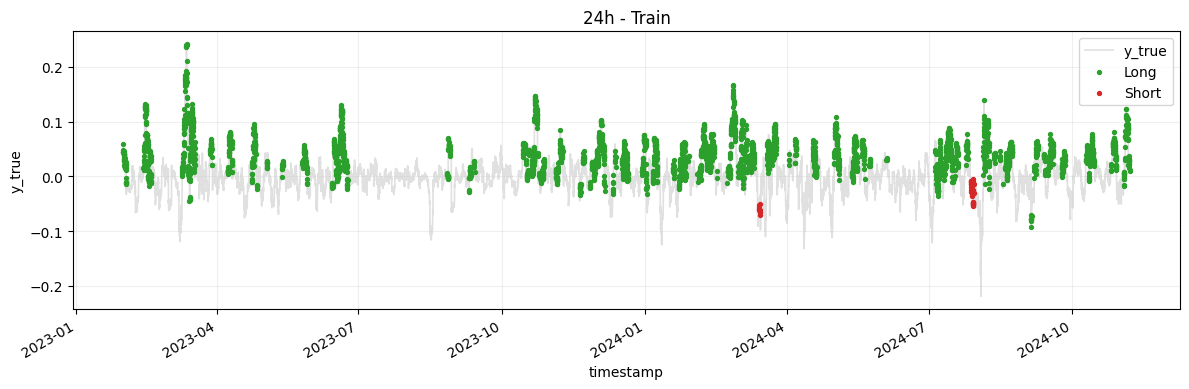

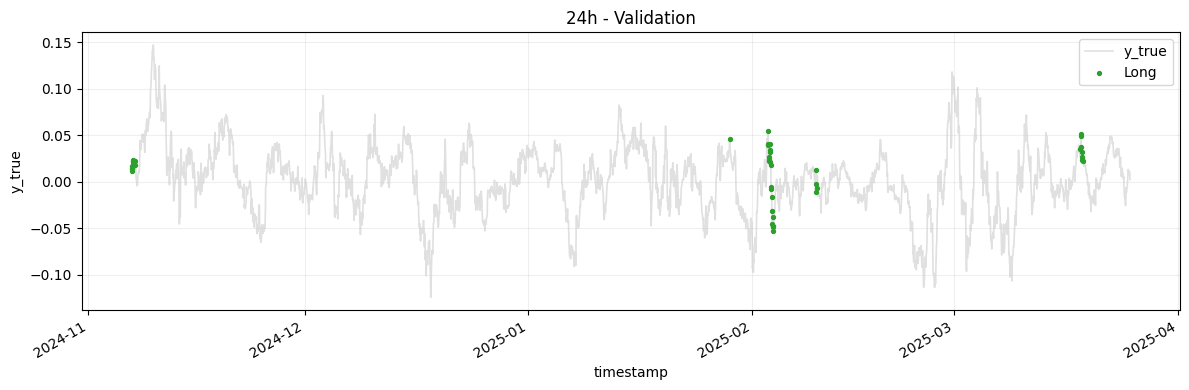

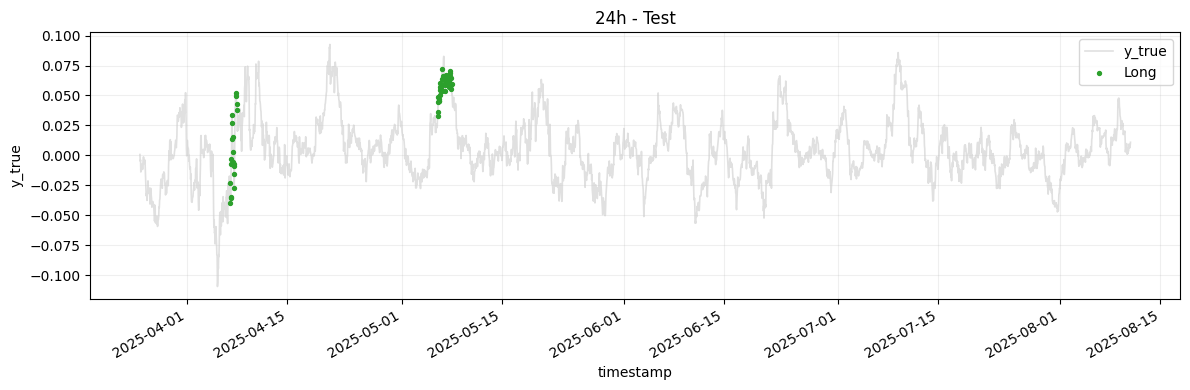

In [71]:
plot_y_true_with_signal_colors(train_ind, title="24h - Train")

plot_y_true_with_signal_colors(val_ind, title="24h - Validation")

plot_y_true_with_signal_colors(test_ind, title="24h - Test")


# Results for 120h log return

In [72]:
from pathlib import Path
import pandas as pd

# Paths
root = Path("/Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_120h")
train_csv = root / "pred_train_signals.csv"
val_csv = root / "pred_val_signals.csv"
test_csv = root / "pred_test_signals.csv"

# Load
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

for df in (train_df, val_df, test_df):
    if 'timestamp' in df.columns:
        ts = pd.to_datetime(df['timestamp'], errors='coerce', utc=True)
        df['timestamp'] = ts.dt.tz_convert('UTC').dt.tz_localize(None)

print("Loaded:")
print("train:", train_df.shape, train_csv)
print("val:", val_df.shape, val_csv)
print("test:", test_df.shape, test_csv)

train_df.head(), val_df.head(), test_df.head()


Loaded:
train: (15453, 20) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_120h/pred_train_signals.csv
val: (3311, 20) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_120h/pred_val_signals.csv
test: (3313, 20) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_120h/pred_test_signals.csv


(            timestamp    y_true  pred_q05  pred_q10  pred_q15  pred_q25  \
 0 2023-01-31 00:00:00  0.020052 -0.076704 -0.051411  0.014310  0.014310   
 1 2023-01-31 01:00:00  0.021190 -0.076704 -0.051411  0.014586  0.014586   
 2 2023-01-31 02:00:00  0.018952 -0.076704 -0.051411  0.014674  0.014674   
 3 2023-01-31 03:00:00  0.022383 -0.076704 -0.051411  0.015676  0.015676   
 4 2023-01-31 04:00:00  0.021943 -0.076704 -0.051411  0.012701  0.012701   
 
    pred_q50  pred_q75  pred_q85  pred_q90  pred_q95  cross_violations  \
 0  0.014310  0.021838  0.024044   0.08092  0.109214                 1   
 1  0.014586  0.021838  0.024044   0.08092  0.109214                 1   
 2  0.014674  0.021838  0.024044   0.08092  0.109214                 1   
 3  0.015676  0.021838  0.024044   0.08092  0.109214                 1   
 4  0.012701  0.022181  0.024044   0.08092  0.109214                 1   
 
    max_cross_gap  exp_ret_avg  exp_ret_conservative   prob_up  tail_spread  \
 0       0.032117

In [73]:
# Load original merged predictions (no signals)
orig_train_csv = root / "pred_train.csv"
orig_val_csv = root / "pred_val.csv"
orig_test_csv = root / "pred_test.csv"

orig_train_df = pd.read_csv(orig_train_csv)
orig_val_df = pd.read_csv(orig_val_csv)
orig_test_df = pd.read_csv(orig_test_csv)

for df in (orig_train_df, orig_val_df, orig_test_df):
    if 'timestamp' in df.columns:
        ts = pd.to_datetime(df['timestamp'], errors='coerce', utc=True)
        df['timestamp'] = ts.dt.tz_convert('UTC').dt.tz_localize(None)

print("Loaded originals:")
print("train:", orig_train_df.shape, orig_train_csv)
print("val:", orig_val_df.shape, orig_val_csv)
print("test:", orig_test_df.shape, orig_test_csv)

orig_train_df.head(), orig_val_df.head(), orig_test_df.head()


Loaded originals:
train: (15453, 11) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_120h/pred_train.csv
val: (3311, 11) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_120h/pred_val.csv
test: (3313, 11) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_120h/pred_test.csv


(            timestamp    y_true  pred_q05  pred_q10  pred_q15  pred_q25  \
 0 2023-01-31 00:00:00  0.020052 -0.076704 -0.051411  0.014310 -0.017807   
 1 2023-01-31 01:00:00  0.021190 -0.076704 -0.051411  0.014586 -0.017807   
 2 2023-01-31 02:00:00  0.018952 -0.076704 -0.051411  0.014674 -0.017807   
 3 2023-01-31 03:00:00  0.022383 -0.076704 -0.051411  0.015676 -0.017807   
 4 2023-01-31 04:00:00  0.021943 -0.076704 -0.051411  0.012701 -0.017807   
 
    pred_q50  pred_q75  pred_q85  pred_q90  pred_q95  
 0 -0.000115  0.021838  0.024044   0.08092  0.109214  
 1 -0.000115  0.021838  0.024044   0.08092  0.109214  
 2 -0.000530  0.021838  0.024044   0.08092  0.109214  
 3 -0.000530  0.021838  0.024044   0.08092  0.109214  
 4 -0.000530  0.022181  0.024044   0.08092  0.109214  ,
             timestamp    y_true  pred_q05  pred_q10  pred_q15  pred_q25  \
 0 2024-11-04 21:00:00  0.130250 -0.077052 -0.053408  0.074706 -0.019589   
 1 2024-11-04 22:00:00  0.119305 -0.077052 -0.053408  0.067

In [74]:
# Add indicator to each split
train_ind = add_prob_exp_q50_indicator(train_df, orig_train_df, tau_long=0.55, tau_short=0.45, exp_col="exp_ret_avg", out_col="signal_prob_exp_q50")
val_ind = add_prob_exp_q50_indicator(val_df, orig_val_df, tau_long=0.55, tau_short=0.45, exp_col="exp_ret_avg", out_col="signal_prob_exp_q50")
test_ind = add_prob_exp_q50_indicator(test_df, orig_test_df, tau_long=0.55, tau_short=0.45, exp_col="exp_ret_avg", out_col="signal_prob_exp_q50")

print("Indicator value counts (train/val/test):")
print(train_ind["signal_prob_exp_q50"].value_counts().sort_index())
print(val_ind["signal_prob_exp_q50"].value_counts().sort_index())
print(test_ind["signal_prob_exp_q50"].value_counts().sort_index())

train_ind.head(), val_ind.head(), test_ind.head()

Indicator value counts (train/val/test):
signal_prob_exp_q50
0    7440
1    8013
Name: count, dtype: int64
signal_prob_exp_q50
0    3142
1     169
Name: count, dtype: int64
signal_prob_exp_q50
0    3282
1      31
Name: count, dtype: int64


(            timestamp    y_true  pred_q05  pred_q10  pred_q15  pred_q25  \
 0 2023-01-31 00:00:00  0.020052 -0.076704 -0.051411  0.014310  0.014310   
 1 2023-01-31 01:00:00  0.021190 -0.076704 -0.051411  0.014586  0.014586   
 2 2023-01-31 02:00:00  0.018952 -0.076704 -0.051411  0.014674  0.014674   
 3 2023-01-31 03:00:00  0.022383 -0.076704 -0.051411  0.015676  0.015676   
 4 2023-01-31 04:00:00  0.021943 -0.076704 -0.051411  0.012701  0.012701   
 
    pred_q50  pred_q75  pred_q85  pred_q90  ...  max_cross_gap  exp_ret_avg  \
 0  0.014310  0.021838  0.024044   0.08092  ...       0.032117     0.016694   
 1  0.014586  0.021838  0.024044   0.08092  ...       0.032393     0.016832   
 2  0.014674  0.021838  0.024044   0.08092  ...       0.032481     0.016876   
 3  0.015676  0.021838  0.024044   0.08092  ...       0.033483     0.017377   
 4  0.012701  0.022181  0.024044   0.08092  ...       0.030508     0.015949   
 
    exp_ret_conservative   prob_up  tail_spread  signal_exp  signa

In [75]:
cum_train = evaluate_indicator(train_ind, 'train')
cum_val = evaluate_indicator(val_ind, 'val')
cum_test = evaluate_indicator(test_ind, 'test')

cum_train.tail(), cum_val.tail(), cum_test.tail()

train: trades=8013, win_rate=0.939, cumulative_pct=40776.119003
val: trades=169, win_rate=0.722, cumulative_pct=696.647035
test: trades=31, win_rate=0.742, cumulative_pct=149.336846


(timestamp
 2024-11-04 16:00:00    40725.304104
 2024-11-04 17:00:00    40737.687552
 2024-11-04 18:00:00    40750.550515
 2024-11-04 19:00:00    40762.857117
 2024-11-04 20:00:00    40776.119003
 dtype: float64,
 timestamp
 2025-03-22 15:00:00    696.647035
 2025-03-22 16:00:00    696.647035
 2025-03-22 17:00:00    696.647035
 2025-03-22 18:00:00    696.647035
 2025-03-22 19:00:00    696.647035
 dtype: float64,
 timestamp
 2025-08-07 16:00:00    149.336846
 2025-08-07 17:00:00    149.336846
 2025-08-07 18:00:00    149.336846
 2025-08-07 19:00:00    149.336846
 2025-08-07 20:00:00    149.336846
 dtype: float64)

<Axes: title={'center': '24h - Test'}, xlabel='timestamp', ylabel='y_true'>

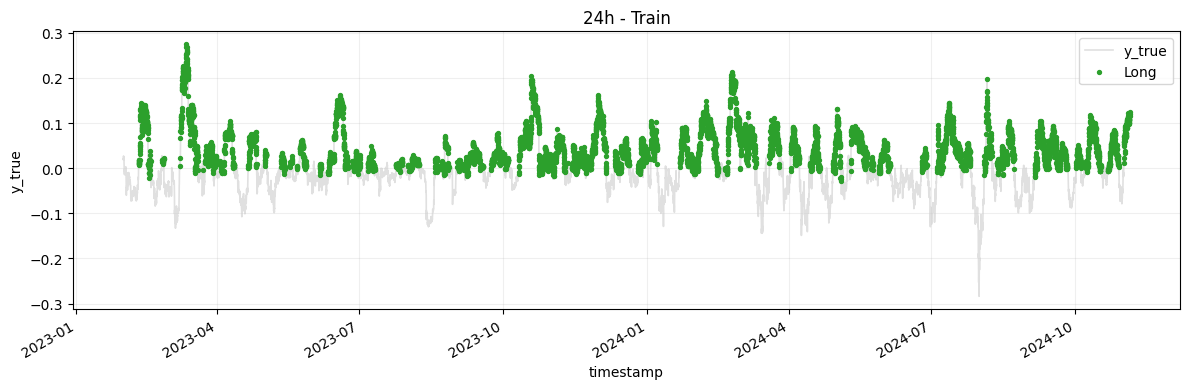

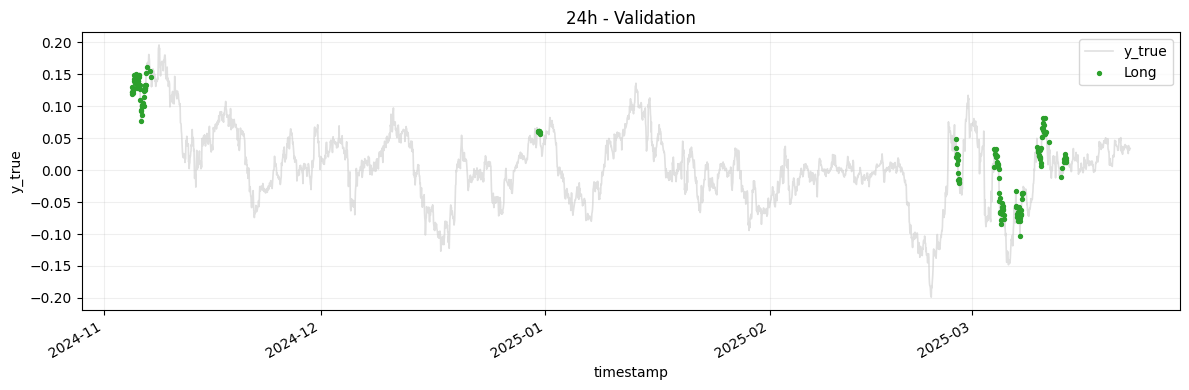

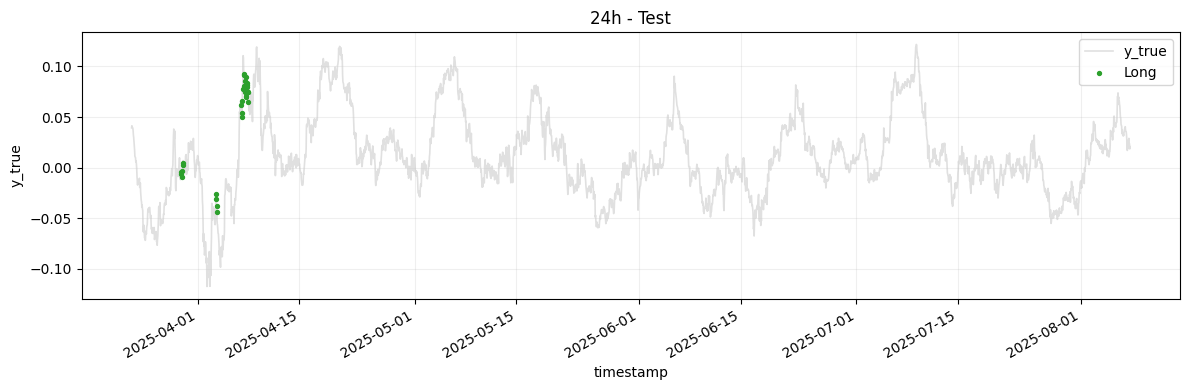

In [76]:
plot_y_true_with_signal_colors(train_ind, title="24h - Train")

plot_y_true_with_signal_colors(val_ind, title="24h - Validation")

plot_y_true_with_signal_colors(test_ind, title="24h - Test")


# 168H

In [77]:
from pathlib import Path
import pandas as pd

# Paths
root = Path("/Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_168h")
train_csv = root / "pred_train_signals.csv"
val_csv = root / "pred_val_signals.csv"
test_csv = root / "pred_test_signals.csv"

# Load
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

for df in (train_df, val_df, test_df):
    if 'timestamp' in df.columns:
        ts = pd.to_datetime(df['timestamp'], errors='coerce', utc=True)
        df['timestamp'] = ts.dt.tz_convert('UTC').dt.tz_localize(None)

print("Loaded:")
print("train:", train_df.shape, train_csv)
print("val:", val_df.shape, val_csv)
print("test:", test_df.shape, test_csv)

train_df.head(), val_df.head(), test_df.head()


Loaded:
train: (15420, 20) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_168h/pred_train_signals.csv
val: (3304, 20) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_168h/pred_val_signals.csv
test: (3305, 20) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_168h/pred_test_signals.csv


(            timestamp    y_true  pred_q05  pred_q10  pred_q15  pred_q25  \
 0 2023-01-31 00:00:00 -0.001561 -0.068196 -0.040108  0.000934  0.000934   
 1 2023-01-31 01:00:00  0.000617 -0.071709 -0.045927 -0.000604 -0.000604   
 2 2023-01-31 02:00:00  0.001163 -0.071709 -0.045927  0.000273  0.000273   
 3 2023-01-31 03:00:00  0.001934 -0.071709 -0.045927  0.000275  0.000275   
 4 2023-01-31 04:00:00  0.000271 -0.071709 -0.044345  0.001351  0.001351   
 
    pred_q50  pred_q75  pred_q85  pred_q90  pred_q95  cross_violations  \
 0  0.000934  0.043886  0.071632  0.086829  0.131005                 1   
 1  0.004683  0.043886  0.071632  0.086829  0.131005                 1   
 2  0.004683  0.043886  0.071632  0.086829  0.131005                 1   
 3  0.004683  0.043886  0.071632  0.086829  0.131005                 1   
 4  0.004683  0.043886  0.071632  0.086829  0.131005                 1   
 
    max_cross_gap  exp_ret_avg  exp_ret_conservative   prob_up  tail_spread  \
 0       0.025163

In [78]:
# Load original merged predictions (no signals)
orig_train_csv = root / "pred_train.csv"
orig_val_csv = root / "pred_val.csv"
orig_test_csv = root / "pred_test.csv"

orig_train_df = pd.read_csv(orig_train_csv)
orig_val_df = pd.read_csv(orig_val_csv)
orig_test_df = pd.read_csv(orig_test_csv)

for df in (orig_train_df, orig_val_df, orig_test_df):
    if 'timestamp' in df.columns:
        ts = pd.to_datetime(df['timestamp'], errors='coerce', utc=True)
        df['timestamp'] = ts.dt.tz_convert('UTC').dt.tz_localize(None)

print("Loaded originals:")
print("train:", orig_train_df.shape, orig_train_csv)
print("val:", orig_val_df.shape, orig_val_csv)
print("test:", orig_test_df.shape, orig_test_csv)

orig_train_df.head(), orig_val_df.head(), orig_test_df.head()


Loaded originals:
train: (15420, 11) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_168h/pred_train.csv
val: (3304, 11) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_168h/pred_val.csv
test: (3305, 11) /Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_168h/pred_test.csv


(            timestamp    y_true  pred_q05  pred_q10  pred_q15  pred_q25  \
 0 2023-01-31 00:00:00 -0.001561 -0.068196 -0.040108  0.000934 -0.024229   
 1 2023-01-31 01:00:00  0.000617 -0.071709 -0.045927 -0.000604 -0.024229   
 2 2023-01-31 02:00:00  0.001163 -0.071709 -0.045927  0.000273 -0.024229   
 3 2023-01-31 03:00:00  0.001934 -0.071709 -0.045927  0.000275 -0.024229   
 4 2023-01-31 04:00:00  0.000271 -0.071709 -0.044345  0.001351 -0.024229   
 
    pred_q50  pred_q75  pred_q85  pred_q90  pred_q95  
 0  0.000254  0.043886  0.071632  0.086829  0.131005  
 1  0.004683  0.043886  0.071632  0.086829  0.131005  
 2  0.004683  0.043886  0.071632  0.086829  0.131005  
 3  0.004683  0.043886  0.071632  0.086829  0.131005  
 4  0.004683  0.043886  0.071632  0.086829  0.131005  ,
             timestamp    y_true  pred_q05  pred_q10  pred_q15  pred_q25  \
 0 2024-11-03 12:00:00  0.151972 -0.062203 -0.022064  0.008896 -0.029782   
 1 2024-11-03 13:00:00  0.159240 -0.062317 -0.021108  0.009

In [79]:
# Add indicator to each split
train_ind = add_prob_exp_q50_indicator(train_df, orig_train_df, tau_long=0.55, tau_short=0.45, exp_col="exp_ret_avg", out_col="signal_prob_exp_q50")
val_ind = add_prob_exp_q50_indicator(val_df, orig_val_df, tau_long=0.55, tau_short=0.45, exp_col="exp_ret_avg", out_col="signal_prob_exp_q50")
test_ind = add_prob_exp_q50_indicator(test_df, orig_test_df, tau_long=0.55, tau_short=0.45, exp_col="exp_ret_avg", out_col="signal_prob_exp_q50")

print("Indicator value counts (train/val/test):")
print(train_ind["signal_prob_exp_q50"].value_counts().sort_index())
print(val_ind["signal_prob_exp_q50"].value_counts().sort_index())
print(test_ind["signal_prob_exp_q50"].value_counts().sort_index())

train_ind.head(), val_ind.head(), test_ind.head()

Indicator value counts (train/val/test):
signal_prob_exp_q50
-1      40
 0    6889
 1    8491
Name: count, dtype: int64
signal_prob_exp_q50
0    2721
1     583
Name: count, dtype: int64
signal_prob_exp_q50
0    2895
1     410
Name: count, dtype: int64


(            timestamp    y_true  pred_q05  pred_q10  pred_q15  pred_q25  \
 0 2023-01-31 00:00:00 -0.001561 -0.068196 -0.040108  0.000934  0.000934   
 1 2023-01-31 01:00:00  0.000617 -0.071709 -0.045927 -0.000604 -0.000604   
 2 2023-01-31 02:00:00  0.001163 -0.071709 -0.045927  0.000273  0.000273   
 3 2023-01-31 03:00:00  0.001934 -0.071709 -0.045927  0.000275  0.000275   
 4 2023-01-31 04:00:00  0.000271 -0.071709 -0.044345  0.001351  0.001351   
 
    pred_q50  pred_q75  pred_q85  pred_q90  ...  max_cross_gap  exp_ret_avg  \
 0  0.000934  0.043886  0.071632  0.086829  ...       0.025163     0.020566   
 1  0.004683  0.043886  0.071632  0.086829  ...       0.023624     0.020564   
 2  0.004683  0.043886  0.071632  0.086829  ...       0.024502     0.020784   
 3  0.004683  0.043886  0.071632  0.086829  ...       0.024504     0.020784   
 4  0.004683  0.043886  0.071632  0.086829  ...       0.025580     0.021132   
 
    exp_ret_conservative   prob_up  tail_spread  signal_exp  signa

In [80]:
cum_train = evaluate_indicator(train_ind, 'train')
cum_val = evaluate_indicator(val_ind, 'val')
cum_test = evaluate_indicator(test_ind, 'test')

cum_train.tail(), cum_val.tail(), cum_test.tail()

train: trades=8531, win_rate=0.957, cumulative_pct=51299.461109
val: trades=583, win_rate=0.753, cumulative_pct=2617.908863
test: trades=410, win_rate=0.654, cumulative_pct=1303.939734


(timestamp
 2024-11-03 07:00:00    51234.183013
 2024-11-03 08:00:00    51249.816689
 2024-11-03 09:00:00    51266.203191
 2024-11-03 10:00:00    51282.515857
 2024-11-03 11:00:00    51299.461109
 dtype: float64,
 timestamp
 2025-03-20 23:00:00    2617.908863
 2025-03-21 00:00:00    2617.908863
 2025-03-21 01:00:00    2617.908863
 2025-03-21 02:00:00    2617.908863
 2025-03-21 03:00:00    2617.908863
 dtype: float64,
 timestamp
 2025-08-05 16:00:00    1303.939734
 2025-08-05 17:00:00    1303.939734
 2025-08-05 18:00:00    1303.939734
 2025-08-05 19:00:00    1303.939734
 2025-08-05 20:00:00    1303.939734
 dtype: float64)

<Axes: title={'center': '24h - Test'}, xlabel='timestamp', ylabel='y_true'>

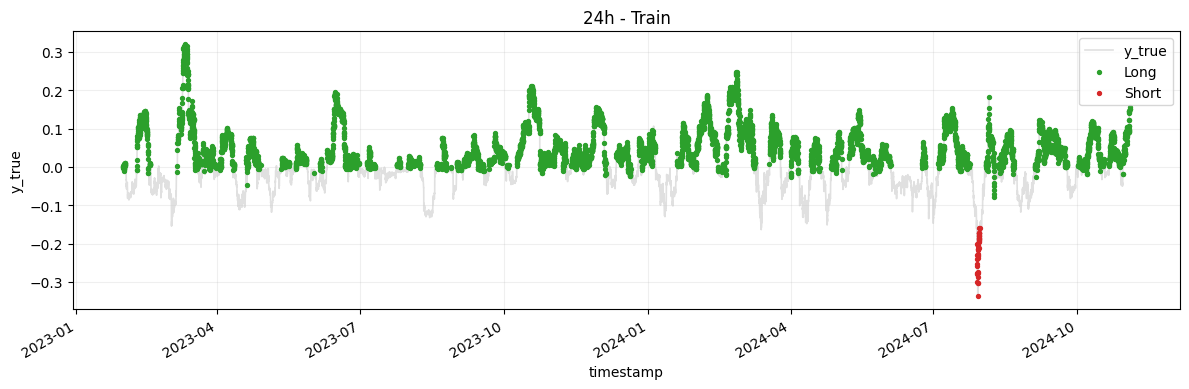

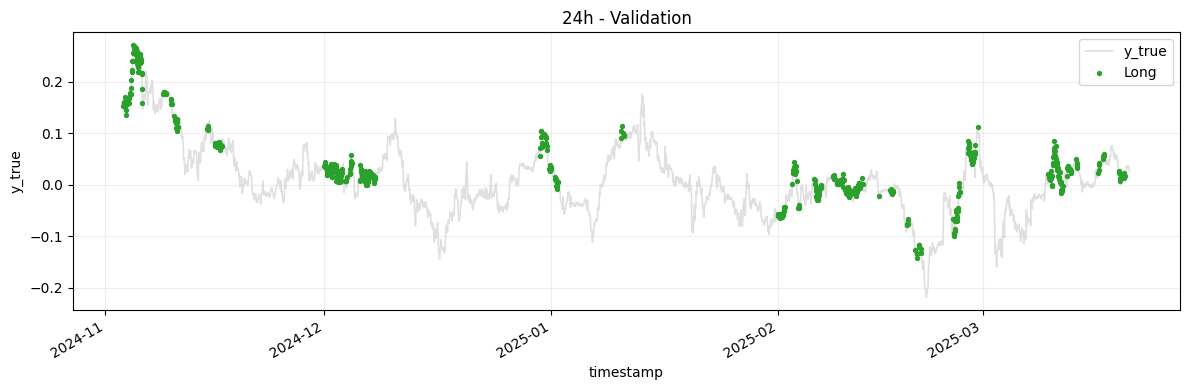

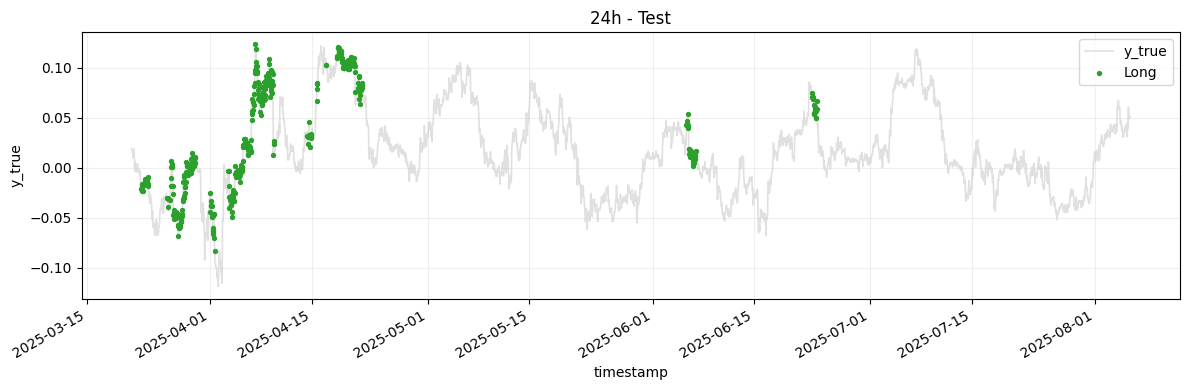

In [81]:
plot_y_true_with_signal_colors(train_ind, title="24h - Train")

plot_y_true_with_signal_colors(val_ind, title="24h - Validation")

plot_y_true_with_signal_colors(test_ind, title="24h - Test")
